Python tutorial
--------------
- sudoku solver part 1 http://opencvpython.blogspot.hu/2012/06/sudoku-solver-part-1.html
- part 2 http://opencvpython.blogspot.hu/2012/06/sudoku-solver-part-2.html
- part 3 http://opencvpython.blogspot.hu/2012/06/sudoku-solver-part-3.html
- part 4 http://opencvpython.blogspot.hu/2012/07/sudoku-extra.html

- http://aishack.in/tutorials/sudoku-grabber-opencv-detection/

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pytesseract
import PIL

import scipy.cluster.hierarchy as hclust
import scipy.constants

print cv2.__version__

3.0.0


In [3]:
def imshow(img,cross=None,scale=1,**kwargs):
    if len(img.shape) < 3 or img.shape[2] == 1:
        rgbimg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        rgbimg = img.copy()
    if cross is not None:
        crossradius = 15
        color = (255,0,0)
        for x in xrange(crossradius):
            rgbimg[cross[1]-x,cross[0]] = color
            rgbimg[cross[1]+x,cross[0]] = color
            rgbimg[cross[1],cross[0]-x] = color
            rgbimg[cross[1],cross[0]+x] = color
    if scale is not None and scale != 1:
        #rgbimg = cv2.resize(rgbimg,(0,0),fx=scale,fy=scale)
        plt.figure(figsize=(4*scale,4*scale))
    return plt.imshow(rgbimg,**kwargs)

In [4]:
def assignColors(x,levels=None,colors=None):
    """Assigns a color to each item of x
    
    x = list:      List of items
    levels = list: (optional) An ordered set of values which x can take. If empty, uses sorted(set(x)). default: None
    colors = dict: (optional) A dictionary mapping levels to colors
    
    returns list of (r,g,b) colors for each 
    """
    if levels is None:
        levels = sorted(set(x))
    
    # hue is in [0,179]
    hsvColors = [(h*scipy.constants.golden_ratio*180 % 180,255,255) for h in xrange(len(levels))]
    rgbColors = cv2.cvtColor( np.array(hsvColors,np.uint8).reshape((len(hsvColors),1,3)), cv2.COLOR_HSV2RGB)
    #lineColors = cv2.cvtColor( np.array([[hsvColors[i-1]] for i in clusters],np.uint8),cv2.COLOR_HSV2RGB)
    colorsdict = dict([(levels[i], rgbColors[i].squeeze().tolist()) for i in xrange(len(levels))])
    if colors is not None:
        colors.update( colorsdict )
    return [colorsdict[v] for v in x]


In [5]:
def drawline(img, line, color, *args, **kw):
    """Works like cv2.line, but takes a line in normal form rather than two endpoints
    
    img = np.array: an image
    line = tuple: (rho, theta) representation of a line. Theta is the
            angle from normal vector to the x axis (in interval [0,PI),
            so that the normal vector has a positive y component).
            Rho is the minimum distance from the origin to the line,
            which may be negative for lines with negative y-intercept.
    """
    rho,theta = line
    if abs(np.tan(theta)) > 2/400.: #more than 1 pixel change
        m = -1/np.tan(theta)
        c = rho/np.sin(theta)
        #print m,c,(img.shape[0], int(m*img.shape[0]+c))
        cv2.line(img, (0,int(c)), (img.shape[0], int(m*img.shape[0]+c)), color, *args, **kw)
    else:
        cv2.line(img, (int(rho),0),(int(rho),img.shape[1]), color, *args, **kw)
        

In [6]:
def normaltoendpoints(imgshape, line):
    """Convert a line in normal form (rho, theta) to two endpoints
    """
    rho, theta = line
    width,height = imgshape[:2]
    if theta < 1./width: # horizontal. tan(epsilon) ~ epsilon, so 1/width ~ tan(1/width)
        if not (0 <= rho < height):
            return None # no intersection
        p1 = (rho,0)
        p2 = (rho,height-1)
    elif abs(theta - np.pi/2) < 1./height: # vertical
        if not (0 <= rho < width):
            return None # no intersection

        p1 = (0,rho)
        p2 = (width-1,rho)
    else:
        # y = m*x + b, or x = (y-b)/m
        m = -1/np.tan(theta)
        b = rho/np.sin(theta)
        
        # intersections with bounding box
        y0 = b #x=0
        y1 = m*width + b #x=width
        x0 = -b/m # y=0
        x1 = (height-b)/m # y=height
        
        # two of these should be within the box
        points = []
        if 0 <= y0 < height:
            points.append( (0, y0) )
        if 0 <= y1 < height:
            points.append( (width-1, y1) )
        if 0 <= x0 < width:
            points.append( (x0, 0) )
        if 0 <= x1 < width:
            points.append( (x1, height-1) )
        
        if len(points) == 1:
            # literal corner case
            p1 = p2 = points[0]
        elif len(points) != 2:
            # misses box
            return None
        else:
            p1, p2 = points
        
    #if np.pi/4 < theta < 3*np.pi/4: # horizontal line
    #    p1 = (0, rho/np.sin(theta) )
    #    p2 = ( imgshape[0], -imgshape[0]/np.tan(theta) + rho/np.sin(theta) )
    #else:
    #    p1 = (rho/np.cos(theta), 0)
    #    p2 = (-imgshape[1]/np.tan(theta) + rho/np.cos(theta), imgshape[1])
    return (tuple(map(int,p1)), tuple(map(int,p2)))
#normaltoendpoints((400,500), (800/np.sqrt(2),np.pi/4) )

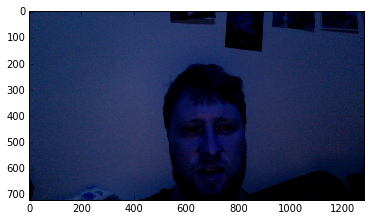

In [7]:
import time
video_capture = cv2.VideoCapture(0)
time.sleep(.1) #for focus
for i in xrange(1):
    ret, frame = video_capture.read()
    if not ret:
        print "no frames"
        break
    imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
video_capture.release()

(423, 419)

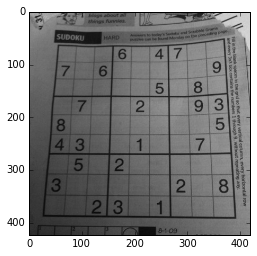

In [8]:
#http://aishack.in/tutorials/sudoku-grabber-with-opencv-plot/
img = cv2.imread('sudoku-original.jpg',cv2.IMREAD_GRAYSCALE)
imshow(img)
img.shape

In [10]:
bgra = cv2.cvtColor(img, cv2.COLOR_GRAY2BGRA)
bgra.shape, img.shape

((423, 419, 4), (423, 419))

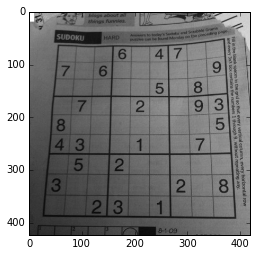

In [11]:
bgra[:20,:10,:] = 255
plt.imshow(bgra)

In [12]:
bgra.flatten().shape
cv2.imread?

GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst


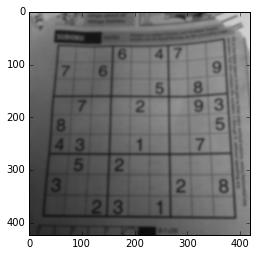

In [13]:
# Blur
print cv2.GaussianBlur.__doc__
blurred = cv2.GaussianBlur(img,(11,11),0)
imshow(blurred)

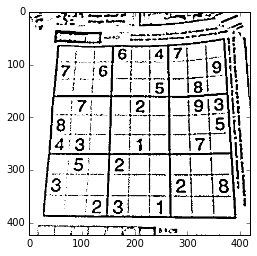

In [14]:
# Adaptive threshold
thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)
imshow(thresholded)

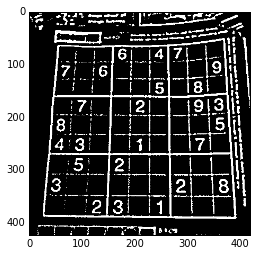

In [15]:
# invert
imshow(~thresholded)

[[0 1 0]
 [1 1 1]
 [0 1 0]]


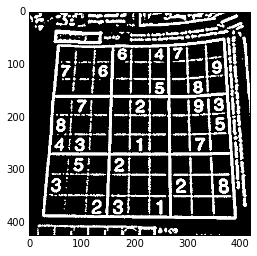

In [16]:
# Dilate by a pixel
#http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
print kernel
dilated = cv2.dilate(~thresholded, kernel, iterations=1)
imshow(dilated)

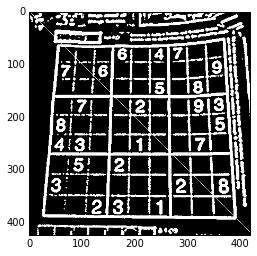

In [17]:
imshow(dilated | np.eye(*dilated.shape,dtype=np.uint8)*255)

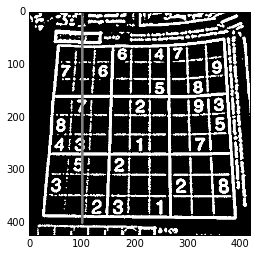

In [18]:
d2 = cv2.line(dilated.copy(), (100,0), (100,400), 128, 3)
imshow(d2)

(15292, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ..., 
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8), (25, 50, 368, 344))


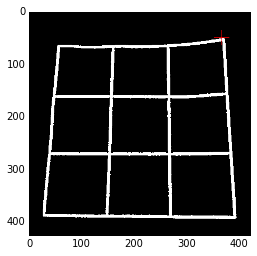

In [19]:
blobimg = dilated.copy()
mask = np.zeros((blobimg.shape[0]+2,blobimg.shape[1]+2), np.uint8)
start = (374, 27)
start = (27,374)
start = (80,47)
start = (365, 50)
ret = cv2.floodFill(blobimg, mask, start, 64, flags= 4 | ( 255 << 8 ))#| cv2.FLOODFILL_MASK_ONLY
print ret
#print (img.shape,ret[1].shape, ret[2].shape,len(ret[3]))
#print (ret[1] is img), (ret[2] is mask)
imshow(mask,cross=start)

In [20]:
# Slow Flood fill to find the largest connected component
def biggestBlob(img):
    """Takes a binary image as input and returns a mask giving the largest connected white component
    """
    filled = img.copy()
    max=-1
    maxPt = None
    maxMask = None
    for y in xrange(img.shape[0]):
        for x in xrange(img.shape[1]):
            if img[y][x] >= 128: # Input should be 0 or 255, but threshold on 128 just in case
                mask = np.zeros((img.shape[0]+2,img.shape[1]+2), np.uint8)
                # 64 is an arbitrary number less than the threshold. Non-zero for debugging.
                area = cv2.floodFill(filled, mask, (x,y), 64, flags= 4 | ( 255 << 8 ))[0]
                #| cv2.FLOODFILL_MASK_ONLY
                
                if area>max:
                    max = area
                    maxPt = (x,y)
                    maxMask = mask
    if maxMask is not None:
        return maxMask[1:-1,1:-1]
    else:
        # All black image; no blob
        return np.zeros(img.shape, np.uint8)

(423, 419)


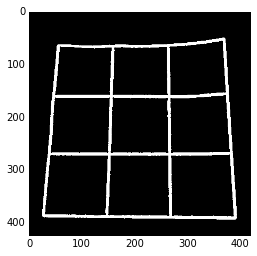

In [21]:
print dilated.shape
d2 = dilated.copy()
blob = biggestBlob(d2)
imshow(blob)


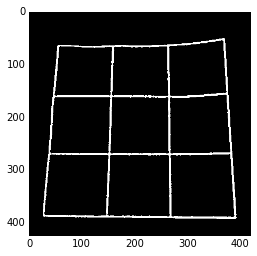

In [22]:
# Erode blob
border = cv2.erode(blob, kernel)
imshow(border)

4 | ( 255 << 8 )

In [23]:
# Segment detector
# Returns (x1,y1,x2,y2)
lines = cv2.HoughLinesP(border,1, np.pi/180, 200)# intercept res (pxl), angle res (radian), threshold
lines[:10]


array([[[366,  51, 390, 391]],

       [[ 26, 386, 345, 391]],

       [[263,  63, 267, 343]],

       [[ 26, 385, 389, 391]],

       [[267, 269, 381, 269]],

       [[ 28, 384,  45, 181]],

       [[376, 168, 376, 180]],

       [[ 39, 270, 265, 270]],

       [[261,  63, 265, 269]],

       [[ 27, 384,  33, 307]]], dtype=int32)

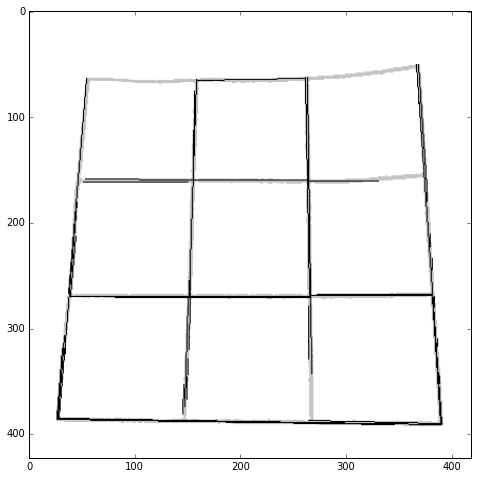

In [24]:
# draw segments black on grey
linesImg = ~border | 196
#linesImg = cv2.cvtColor(linesImg, cv2.COLOR_GRAY2RGB)
for line in lines:
    cv2.line(linesImg,tuple(line[0,:2]),tuple(line[0,2:]),0,1)
imshow(linesImg,scale=2)

In [25]:
# Full line detection
# Returns (intercept, slope)
lines = cv2.HoughLines(blob,1, np.pi/180, 200)# intercept res (pxl), angle res (radian), threshold
#lines = cv2.HoughLines(~thresholded,1, np.pi/180, 200)# intercept res (pxl), angle res (radian), threshold
print "\n".join(["%d\t%.1f"%(l[0,0],180/np.pi*l[0,1]) for l in lines[:10]])

384	91.0
388	90.0
270	90.0
268	90.0
-362	176.0
-366	177.0
164	89.0
273	89.0
-262	179.0
159	90.0


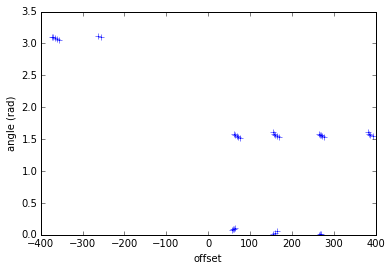

In [26]:
#plt.plot(lines.squeeze())
plt.plot(lines[:,0,0],lines[:,0,1],'+')
plt.xlabel('offset')
plt.ylabel('angle (rad)')

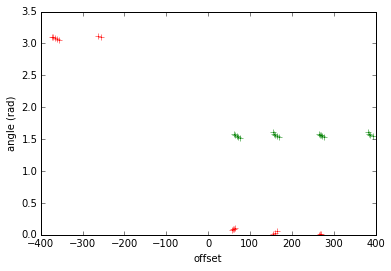

In [27]:
horizontal = lines[np.logical_not(np.logical_and(np.pi/4 <= lines[:,0,1],lines[:,0,1] < np.pi*3/4)),0,:]
vertical = lines[np.logical_and(np.pi/4 <= lines[:,0,1],lines[:,0,1] < np.pi*3/4),0,:]
plt.plot(horizontal[:,0],horizontal[:,1],'r+',
         vertical[:,0],vertical[:,1],'g+')
plt.xlabel('offset')
plt.ylabel('angle (rad)')

In [28]:
np.hstack([np.mod(horizontal[:,1]+np.pi/2,np.pi),np.array([1,2,3])])

array([ 1.500983  ,  1.51843619,  1.55334306,  1.57079637,  1.605703  ,
        1.65806282,  1.65806282,  1.62315631,  1.67551613,  1.58824968,
        1.6406095 ,  1.53588986,  1.48352981,  1.53588986,  1.58824968,
        1.53588986,  1.58824968,  1.        ,  2.        ,  3.        ])

horizontal: 0.000159204053027 1.58776241067
vertical: 5.76914895518e-05 1.55390595933
average: 7.85740697907e-05 1.56569666729


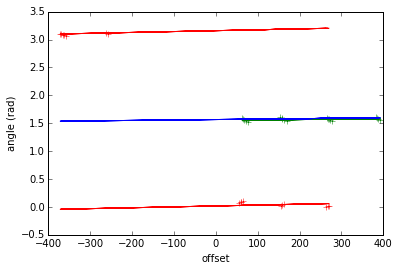

In [29]:
hm,hc=np.linalg.lstsq(np.vstack([horizontal[:,0], np.ones(horizontal.shape[0])]).T,
                      np.mod(horizontal[:,1]+np.pi/2,np.pi))[0]
vm,vc=np.linalg.lstsq(np.vstack([vertical[:,0], np.ones(vertical.shape[0])]).T,
                      vertical[:,1])[0]
print "horizontal:",hm,hc
print "vertical:",vm,vc
am,ac=np.linalg.lstsq(np.vstack([np.hstack([horizontal[:,0],vertical[:,0]]),
                                 np.ones(horizontal.shape[0]+vertical.shape[0])]).T,
                      np.hstack([np.mod(horizontal[:,1]+np.pi/2,np.pi),vertical[:,1]]) )[0]
print "average:",am,ac
plt.plot(horizontal[:,0],horizontal[:,1],'r+',
         horizontal[:,0],hm*horizontal[:,0]+hc+np.pi/2,'r-',
         horizontal[:,0],hm*horizontal[:,0]+hc-np.pi/2,'r-',
         vertical[:,0],vertical[:,1],'g+',
         vertical[:,0],vm*vertical[:,0]+vc,'g-',
         np.hstack([horizontal[:,0],vertical[:,0]]),am*np.hstack([horizontal[:,0],vertical[:,0]])+ac,'b-'
        )
plt.xlabel('offset')
plt.ylabel('angle (rad)')

In [30]:
lines.squeeze()[0:1]
np.array([[0,0]])[0][1]

0

[(4.0, -0.017453194),
 (-4.0, 0.017453194),
 (-100.0, -0.052359819),
 (100.0, 0.052359819),
 (-626.0, 3.0717795),
 (626.0, -3.0717795),
 (-521.0, 3.0368729),
 (521.0, -3.0368729),
 (-423.0, 2.984513),
 (423.0, -2.984513)]

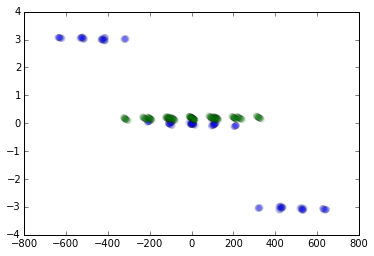

In [31]:
patterson1 = []
patterson2 = []
for pt1 in xrange(len(horizontal)):
    for pt2 in xrange(pt1+1,len(horizontal)):
        #print pt1,pt2,pt1-pt2
        patterson1.append(tuple(horizontal[pt1]-horizontal[pt2]))
        patterson1.append(tuple(horizontal[pt2]-horizontal[pt1]))
for pt1 in xrange(len(vertical)):
    for pt2 in xrange(pt1+1,len(vertical)):
        #print pt1,pt2,pt1-pt2
        patterson2.append(tuple(vertical[pt1]-vertical[pt2]))
        patterson2.append(tuple(vertical[pt2]-vertical[pt1]))

plt.plot([i for i,j in patterson1],[j for i,j in patterson1],'ob',
         [i for i,j in patterson2],[j+.2 for i,j in patterson2],'og',alpha=0.1)
patterson1[:10]

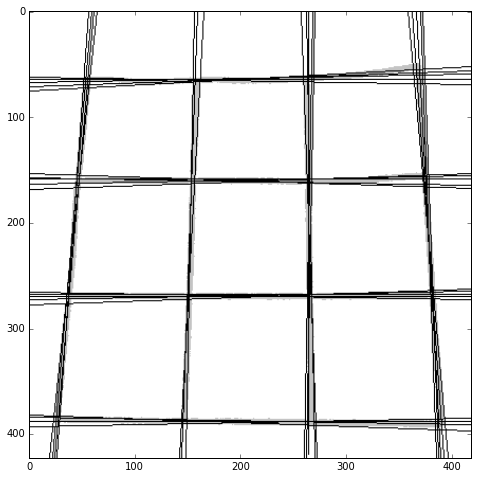

In [32]:
linesImg = ~blob | 196
#linesImg = ~thresholded | 196
for line in lines.squeeze()[:100]:#[[(100,np.pi/4)]]
    drawline(linesImg,line,0)
imshow(linesImg,scale=2)

In [33]:
# cluster lines in normal representation
linkagemat = hclust.linkage(lines.squeeze(),method='centroid')
#linkagemat

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


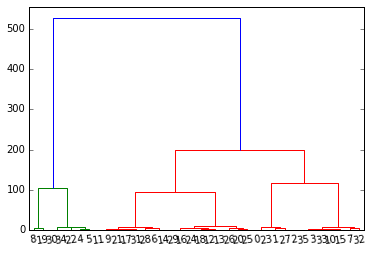

In [34]:
plt.show(hclust.dendrogram(linkagemat))

In [35]:
clusters = hclust.fcluster(linkagemat, 50, 'distance')
clusters

array([5, 5, 6, 6, 2, 2, 3, 6, 1, 3, 6, 3, 4, 4, 3, 6, 4, 3, 4, 1, 4, 3, 2,
       5, 4, 4, 4, 5, 3, 4, 2, 3, 6, 6, 2, 6], dtype=int32)

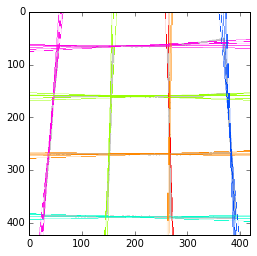

In [36]:
lineColors = assignColors(clusters)
linesImg = ~border | 196
linesImg = cv2.cvtColor(linesImg,cv2.COLOR_GRAY2RGB)
for line,col in zip(lines.squeeze(),lineColors):#[[(100,np.pi/4)]]
    #print line[0], col[0], type(col[0].tolist()[0])
    drawline(linesImg,line,col)
    #cv2.line(linesImg, (0,0), (np.random.randint(img.shape[0]),np.random.randint(img.shape[1])), col[0].tolist() )
imshow(linesImg)

In [37]:
# cluster lines in endpoint representation
endpoints = [sum(normaltoendpoints(border.shape,line),()) for line in lines.squeeze()]
linkagemat = hclust.linkage(endpoints,method='centroid')
#[sum(normaltoendpoints(border.shape,line),()) for line in lines.squeeze()]

In [38]:
sorted(endpoints)

[(0, 63, 422, 70),
 (0, 65, 422, 65),
 (0, 68, 422, 60),
 (0, 72, 422, 57),
 (0, 76, 422, 53),
 (0, 154, 422, 168),
 (0, 158, 422, 165),
 (0, 159, 422, 159),
 (0, 164, 422, 156),
 (0, 169, 422, 154),
 (0, 266, 422, 273),
 (0, 268, 422, 268),
 (0, 270, 422, 270),
 (0, 273, 422, 265),
 (0, 278, 422, 263),
 (0, 382, 422, 397),
 (0, 384, 422, 391),
 (0, 388, 422, 388),
 (0, 393, 422, 385),
 (56, 0, 26, 418),
 (59, 0, 22, 418),
 (61, 0, 24, 418),
 (64, 0, 20, 418),
 (156, 0, 148, 418),
 (159, 0, 144, 418),
 (164, 0, 142, 418),
 (257, 0, 271, 418),
 (262, 0, 269, 418),
 (264, 0, 264, 418),
 (268, 0, 260, 418),
 (270, 0, 262, 418),
 (358, 0, 395, 418),
 (362, 0, 392, 418),
 (366, 0, 388, 418),
 (370, 0, 384, 418),
 (372, 0, 386, 418)]

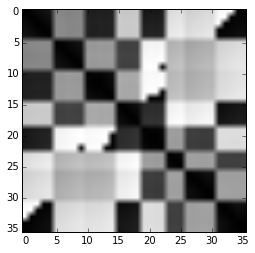

In [39]:
mat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(sorted(endpoints)))
imshow(np.asarray(mat,np.uint8))

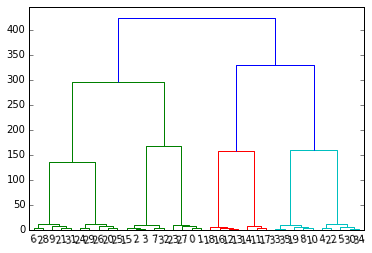

In [40]:
plt.show(hclust.dendrogram(linkagemat))

In [41]:
#TODO Calculate distance based on 1/18th of blob size
# sqrt( 2*(400/18)^2) or something?
clusters = hclust.fcluster(linkagemat, 50, 'distance')
clusters

array([4, 4, 3, 3, 8, 8, 1, 3, 7, 1, 7, 6, 5, 5, 6, 3, 5, 6, 5, 7, 2, 1, 8,
       4, 2, 2, 2, 4, 1, 2, 8, 1, 3, 7, 8, 7], dtype=int32)

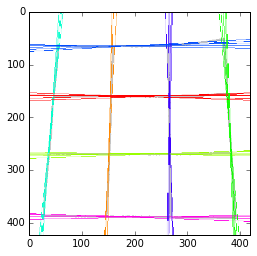

In [42]:
lineColors = assignColors(clusters)
linesImg = ~border | 196
linesImg = cv2.cvtColor(linesImg,cv2.COLOR_GRAY2RGB)
for line,col in zip(lines.squeeze(),lineColors):#[[(100,np.pi/4)]]
    #print line[0], col[0], type(col[0].tolist()[0])
    drawline(linesImg,line,col)
    #cv2.line(linesImg, (0,0), (np.random.randint(img.shape[0]),np.random.randint(img.shape[1])), col[0].tolist() )
imshow(linesImg)

In [43]:
#sorted(zip(clusters,endpoints,lineColors))

In [44]:
clusters

array([4, 4, 3, 3, 8, 8, 1, 3, 7, 1, 7, 6, 5, 5, 6, 3, 5, 6, 5, 7, 2, 1, 8,
       4, 2, 2, 2, 4, 1, 2, 8, 1, 3, 7, 8, 7], dtype=int32)

In [45]:
clust=8#for clust in set(clusters):
lines[clusters == clust,0,:]

array([[-362.        ,    3.07177949],
       [-366.        ,    3.08923268],
       [-357.        ,    3.05432606],
       [-370.        ,    3.10668612],
       [-372.        ,    3.10668612]], dtype=float32)

In [46]:
np.hstack([abs(lines[clusters == clust,0,0:1]),
          lines[clusters == clust,0,1:2] - np.signbit(lines[clusters == clust,0,0:1])*np.pi])

array([[  3.62000000e+02,  -6.98131641e-02],
       [  3.66000000e+02,  -5.23599704e-02],
       [  3.57000000e+02,  -8.72665962e-02],
       [  3.70000000e+02,  -3.49065383e-02],
       [  3.72000000e+02,  -3.49065383e-02]])

In [47]:
def circAvg(x,period=2*np.pi):
    s = np.average(np.sin(x))
    c = np.average(np.cos(x))
    return np.arctan2(s,c)
circAvg(np.array([0,0,np.pi/2]))*180/np.pi

26.56505117707799

In [48]:
def avgLine(lines):
    #Make the first component positive
    r = np.hstack([abs(lines[:,0:1]),
          lines[:,1:2] - np.signbit(lines[:,0:1])*np.pi])
    # Wrap the angle to

In [49]:
uniqLines = [np.average(
            np.hstack([abs(lines[clusters == clust,0,0:1]),
          lines[clusters == clust,0,1:2] - np.signbit(lines[clusters == clust,0,0:1])*np.pi]),
            axis=0) for clust in set(clusters)]

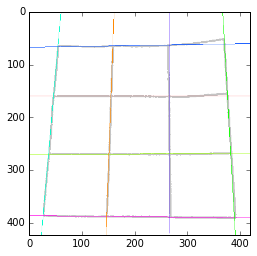

In [50]:
uniqLineColors = set(zip(clusters,[ tuple(t) for t in lineColors]))
uniqLinesImg = cv2.cvtColor(~border | 196,cv2.COLOR_GRAY2RGB)
for line,clustcol in zip(uniqLines,sorted(uniqLineColors)):#[[(100,np.pi/4)]]
    drawline(uniqLinesImg,line,clustcol[1])
imshow(uniqLinesImg)

In [51]:
zip(uniqLines,sorted(uniqLineColors))

[(array([ 160.8       ,    1.57079632]), (1, (255, 0, 0))),
 (array([ 68.8       ,   1.55334303]), (2, (0, 76, 255))),
 (array([ 271.        ,    1.56381502]), (3, (153, 255, 0))),
 (array([ 386.75      ,    1.57952297]), (4, (255, 0, 229))),
 (array([ 60.        ,   0.08726646]), (5, (0, 255, 204))),
 (array([  1.59666667e+02,   3.49065854e-02]), (6, (255, 136, 0))),
 (array([  2.64200000e+02,  -3.49065964e-03]), (7, (60, 0, 255))),
 (array([  3.65400000e+02,  -5.58505615e-02]), (8, (17, 255, 0)))]

In [52]:
#Calculate all line intersections

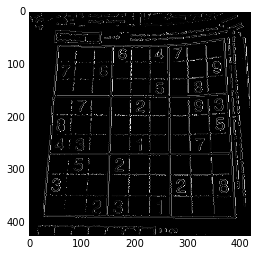

In [53]:
# From http://opencvpython.blogspot.hu/2012/06/sudoku-solver-part-2.html
contourImg, contours, hierarchy = cv2.findContours((~thresholded).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imshow(contourImg)

In [54]:
biggest = None
max_area = 0
for i in contours:
        area = cv2.contourArea(i)
        if area > 100:
                peri = cv2.arcLength(i,True)
                approx = cv2.approxPolyDP(i,0.02*peri,True)
                if area > max_area and len(approx)==4:
                        biggest = approx
                        max_area = area
biggest, max_area

(array([[[369,  52]],
 
        [[ 54,  64]],
 
        [[ 26, 387]],
 
        [[389, 392]]], dtype=int32), 111516.5)

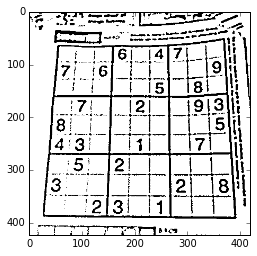

In [55]:
imshow(cv2.drawContours(thresholded, biggest, 1,128))

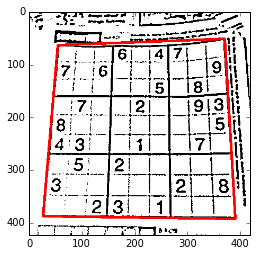

In [56]:
rgbimg = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
plt.imshow(cv2.drawContours(rgbimg,[biggest],-1,(255,0,0),3))

In [57]:
tl,_,_,br = zip(*sorted(zip(np.sum(biggest.squeeze(),axis=1),biggest.squeeze())))[1]
bl,_,_,tr = zip(*sorted(zip(biggest[:,0,0]-biggest[:,0,1],biggest.squeeze())))[1]
corners = np.vstack([tl,tr,br,bl])
corners

array([[ 54,  64],
       [369,  52],
       [389, 392],
       [ 26, 387]], dtype=int32)

In [58]:
width = height = 500
correctedCorners = np.array([ [0,0],[height-1,0],
            [height-1,width-1],[0,width-1] ],np.float32)

In [59]:
correction = cv2.getPerspectiveTransform(np.array(corners,np.float32),correctedCorners)
correction

array([[  1.73948304e+00,   1.50791099e-01,  -1.03582715e+02],
       [  7.06748238e-02,   1.85521412e+00,  -1.22550144e+02],
       [  1.86007071e-04,   4.96300153e-04,   1.00000000e+00]])

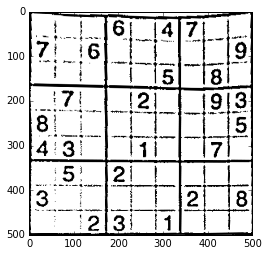

In [60]:
warp = cv2.warpPerspective(thresholded,correction,(height,width))
imshow(warp)

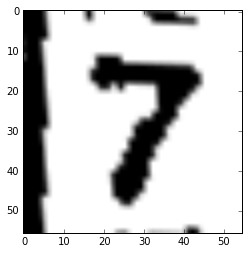

In [61]:
cell = warp[height/9:2*height/9,0:width/9]
imshow(cell)

In [62]:
#p = PIL.Image.fromarray(cell)
#p = PIL.Image.open('sudoku-original.jpg')
#p.show()
#pytesseract.image_to_string(p)

In [64]:
def getCellContents(image,col,row,width=9,height=9):
    pass

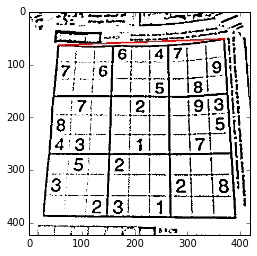

In [80]:
l = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGRA)
cv2.line(l,tuple(corners[0,:].tolist()),tuple(corners[1,:].tolist()),(255,0,0),2)
plt.imshow(l)

In [73]:
corners[0,:].tolist()

[54, 64]

In [84]:
tuple(np.array(.5*corners[0,:],np.uint8))

(27, 32)

In [82]:
cv2.COLOR_BGRA2GRAY

AttributeError: 'module' object has no attribute 'COLOR_GRAY2'